# Загрузка и импорт

In [ ]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=6d718ecc77bb536e76f55ff1526ab3d0123b34b72f77426fc7393a47ad4d32be
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
%matplotlib inline

In [ ]:

import torch
import torchvision
import torchvision.transforms as transforms
 
import torch.nn as nn
import torch.nn.functional as F
 
import torch.optim as optim
 
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from efficientnet_pytorch import EfficientNet

from PIL import Image,ImageStat
import cv2
import json
import matplotlib as mpl
from matplotlib.gridspec import GridSpec 
import math 
import os
import shutil
import random

print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Using torch 1.9.0+cu102 (Tesla T4)


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
def imshow(img):
    """
    Отображает картинку 
    :param img: нормализованный тензор - картинка 
    """
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

In [ ]:
def imshow_in_ax(img,ax):
    """
    Отображает картинку в конкретных осях 
    :param img: нормализованный тензор - картинка
    :param ax: объект осей 
    """
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_axis_off()
    

In [ ]:
def show_dataset(dataset, n=6,m=10):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(m)))
  plt.imshow(img)
  plt.axis('off')

# Предварительная модель

## Детекция автомобиля на фото с помомщю yolov5


In [ ]:
# Классы, которые будем детектировать
MAIN_CLASSES = [ 'car', 'truck', 'bus']

In [ ]:
# Загрузка тестовых данных

img_folder_path = 'drive/MyDrive/pics'
# tr = transforms.ToTensor()
import glob
imgs = []
for filename in glob.glob(f'{img_folder_path}/*.jpg'):
    im=Image.open(filename)
    imgs.append(im)
print(f"Found {len(imgs)} pics in {img_folder_path}/")

# imgs = torchvision.datasets.ImageFolder(root=img_folder_path)

Found 10 pics in drive/MyDrive/pics/


In [ ]:
# Загрузка модели yolov5

yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2021-7-18 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)



  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
# применение yolov5
results = yolo(imgs)

results.print() 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


image 1/10: 683x1024 3 persons, 1 truck
image 2/10: 450x900 1 person, 1 car, 1 truck
image 3/10: 800x1200 2 persons, 6 cars, 1 truck
image 4/10: 183x275 5 cars, 1 truck
image 5/10: 640x640 4 cars
image 6/10: 169x300 1 truck
image 7/10: 288x480 3 cars, 1 bus
image 8/10: 175x289 1 car
image 9/10: 555x740 1 truck
image 10/10: 156x322 1 person, 1 truck
Speed: 13.4ms pre-process, 13.0ms inference, 11.0ms NMS per image at shape (10, 3, 640, 640)


In [ ]:
from numpy.core.fromnumeric import size
# Функции для нарезки картинки 

def save_one_box(xyxy, im, file='image.jpg', gain=1.02, pad=10, square=False, BGR=False, save=True):
    # Save image crop as {file} with crop size multiple {gain} and {pad} pixels. Save and/or return crop
    xyxy = torch.tensor(xyxy).view(-1, 4)
    b = xyxy2xywh(xyxy)  # boxes
    if square:
        b[:, 2:] = b[:, 2:].max(1)[0].unsqueeze(1)  # attempt rectangle to square
    b[:, 2:] = b[:, 2:] * gain + pad  # box wh * gain + pad
    xyxy = xywh2xyxy(b).long()
    clip_coords(xyxy, im.shape)
    crop = im[int(xyxy[0, 1]):int(xyxy[0, 3]), int(xyxy[0, 0]):int(xyxy[0, 2]), ::(1 if BGR else -1)]
    # if save:
    #     cv2.imwrite(file, crop)
    return crop

def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y


def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

def clip_coords(boxes, shape):
    # Clip bounding xyxy bounding boxes to image shape (height, width)
    if isinstance(boxes, torch.Tensor):  # faster individually
        boxes[:, 0].clamp_(0, shape[1])  # x1
        boxes[:, 1].clamp_(0, shape[0])  # y1
        boxes[:, 2].clamp_(0, shape[1])  # x2
        boxes[:, 3].clamp_(0, shape[0])  # y2
    else:  # np.array (faster grouped)
        boxes[:, [0, 2]] = boxes[:, [0, 2]].clip(0, shape[1])  # x1, x2
        boxes[:, [1, 3]] = boxes[:, [1, 3]].clip(0, shape[0])  # y1, y2

def get_largest(img_list):
    # Возвращает наибольшую картинку из списка
    return max(img_list,key = size)

In [ ]:
# Нарезка картинки 

main_crop_list = []
names = results.names
for pred,imc,filename in zip(enumerate(results.pred),imgs,results.files):
  i, det = pred
  imc = np.array(imc)
  crop_list = []
  for *xyxy, conf, cls in reversed(det):
    # title = f"{conf} -- {cls}"
    c = int(cls)  # integer class
    if names[c] in MAIN_CLASSES: 
        print(f'{len(crop_list)} \t FOUND {names[c]} \tIN {filename}\t ACC: {conf}')
        crop= save_one_box(xyxy, imc, BGR=True)
        crop = Image.fromarray(crop)
        crop_list.append(crop)
  if len(crop_list)>0:
    print(f'Total {len(crop_list)} crops in {filename}\n')
    main_crop = get_largest(crop_list)
    main_crop_list.append(main_crop)

0 	 FOUND truck 	IN tractor.jpg	 ACC: 0.5234375
Total 1 crops in tractor.jpg

0 	 FOUND truck 	IN pol1.jpg	 ACC: 0.5517578125
1 	 FOUND car 	IN pol1.jpg	 ACC: 0.70556640625
Total 2 crops in pol1.jpg

0 	 FOUND car 	IN fire.jpg	 ACC: 0.265380859375
1 	 FOUND car 	IN fire.jpg	 ACC: 0.390380859375
2 	 FOUND truck 	IN fire.jpg	 ACC: 0.58154296875
3 	 FOUND car 	IN fire.jpg	 ACC: 0.7216796875
4 	 FOUND car 	IN fire.jpg	 ACC: 0.77685546875
5 	 FOUND car 	IN fire.jpg	 ACC: 0.84033203125
6 	 FOUND car 	IN fire.jpg	 ACC: 0.8662109375
Total 7 crops in fire.jpg

0 	 FOUND car 	IN amb1.jpg	 ACC: 0.318603515625
1 	 FOUND car 	IN amb1.jpg	 ACC: 0.392578125
2 	 FOUND truck 	IN amb1.jpg	 ACC: 0.45556640625
3 	 FOUND car 	IN amb1.jpg	 ACC: 0.47021484375
4 	 FOUND car 	IN amb1.jpg	 ACC: 0.5458984375
5 	 FOUND car 	IN amb1.jpg	 ACC: 0.763671875
Total 6 crops in amb1.jpg

0 	 FOUND car 	IN police.jpg	 ACC: 0.2509765625
1 	 FOUND car 	IN police.jpg	 ACC: 0.311279296875
2 	 FOUND car 	IN police.jpg	 ACC: 0.

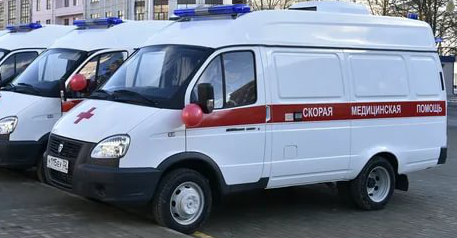

In [ ]:
main_crop_list[6]

## Классификация автомобиля предобученным EfficientNet


In [ ]:
def predict_img(img,classifier,labels,display_classes = None):
  """
  Отображает картинку и предсказывает вероятности всех классов
  :param img: картинка 
  :param classifier: классификатор
  :param labels: подписи классов
  """
  classifier.eval()
  imshow(img)
  
  with torch.no_grad():
      outputs = classifier(img.unsqueeze(0).to(device))
  
  all_cls = len(outputs[0])
  if display_classes:
    num_cls = display_classes if display_classes<=all_cls else all_cls
  else:
    num_cls = all_cls

  # Print predictions
  print('-----')
  for idx in torch.topk(outputs, k=num_cls).indices.squeeze(0).tolist():
      prob = torch.softmax(outputs, dim=1)[0, idx].item()
      print('{label:<75} ({p:.2f}%)'.format(label=labels[idx], p=prob*100))

In [ ]:
def predict_few_imgs(imgs,classifier,labels,figsize=None):
  """
  Отображает картинки с предсказаниями
  :param imgs: список картинок 
  :param classifier: классификатор
  :param labels: подписи классов
  """
  classifier.eval()

  fig = plt.figure(constrained_layout=True,figsize=figsize)
  spec = GridSpec(ncols=2, nrows = math.ceil(len(imgs)/2), figure=fig)
  with torch.no_grad():
      for i,img in enumerate(imgs):
          pred = classifier(img.unsqueeze(0).to(device))
          # plt.subplot(i)
          ax = fig.add_subplot(spec[i//2,i%2])
          idx = int(torch.topk(pred,1).indices)
          prob = torch.softmax(pred, dim=1)[0, idx].item()
          title = f'{labels[idx]} ({prob*100:.2f})'
          plt.title(title)
          imshow_in_ax(img,ax)

In [ ]:
# Загружаем предобученный классификатор
pretrained_EfficientNet = EfficientNet.from_pretrained('efficientnet-b0').to(device)

Loaded pretrained weights for efficientnet-b0


In [ ]:
!wget https://raw.githubusercontent.com/lukemelas/EfficientNet-PyTorch/master/examples/simple/labels_map.txt

--2021-07-16 23:14:41--  https://raw.githubusercontent.com/lukemelas/EfficientNet-PyTorch/master/examples/simple/labels_map.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31565 (31K) [text/plain]
Saving to: ‘labels_map.txt’

labels_map.txt      100%[===================>]  30.83K  --.-KB/s    in 0s      

2021-07-16 23:14:42 (136 MB/s) - ‘labels_map.txt’ saved [31565/31565]



In [ ]:
# Load class names
labels_map = json.load(open('labels_map.txt'))
labels_map = [labels_map[str(i)] for i in range(1000)]

In [ ]:
tfms = transforms.Compose([transforms.Resize((224,224)),
                           transforms.ToTensor(),
                           transforms.Normalize(0.5, 0.5, 0.5)])
# croped_imgs = map(Image.fromarray,crop_list)
croped_imgs = list(map(tfms,main_crop_list))


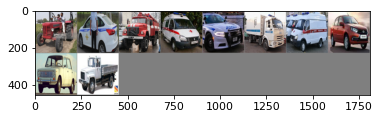

In [ ]:
imshow(torchvision.utils.make_grid(croped_imgs))

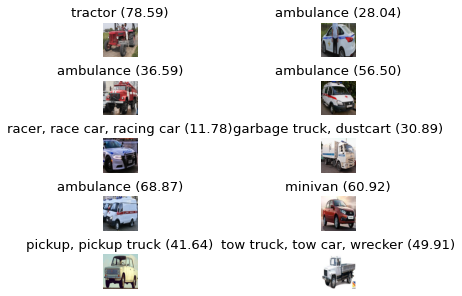

In [ ]:
pretrained_EfficientNet.eval()
predict_few(croped_imgs,pretrained_EfficientNet,labels_map)

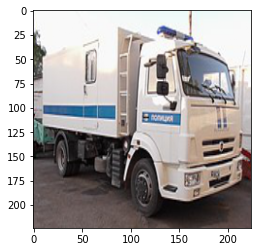

-----
garbage truck, dustcart                                                     (30.89%)
trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi  (21.38%)
moving van                                                                  (17.43%)
tow truck, tow car, wrecker                                                 (3.29%)
recreational vehicle, RV, R.V.                                              (2.43%)


In [ ]:
img = croped_imgs[5]
predict_img(img,pretrained_EfficientNet,labels_map,display_classes=5)


**Предобученный классификатор плохо справляется с задачей**

# Обучение классфикатора



## Подготовка датасета


Имеем картинки, распределенные по папкам в соответствии с классами


In [ ]:
DATAPATH = '/content/drive/MyDrive/Datasets/'

In [ ]:
all_data_path = DATAPATH+"all_data/"
classes = os.listdir(all_data_path)
classes

['ambulance', 'fire-truck', 'police', 'tractor', 'common']

In [ ]:
# Переименовываем и подсчитываем картинки
for cls in tqdm(classes):
  path = f'{all_data_path}{cls}/'
  listdir = os.listdir(path)
  for i, filename in enumerate(listdir):
    new_filename = f'{cls}-{i:03}.jpg'
    os.rename(path+filename,path+new_filename)
  print(f"Renamed {len(listdir)} files of class {cls}")

Renamed 483 files of class ambulance
Renamed 160 files of class fire-truck
Renamed 154 files of class police
Renamed 161 files of class tractor
Renamed 745 files of class common



In [ ]:
def mkdir(path):
  # safe mkdir
  if not os.path.isdir(path):
    os.mkdir(path)
  else:
    print(f"Folder {path} already exist")

In [ ]:
# разбиваем датасет на тренировочную и тестовую выборку

train_size, test_size = 140, 20

mkdir(f'{DATAPATH}train/')
mkdir(f'{DATAPATH}test/')

for cls in tqdm(['common']):
  path = f'{all_data_path}{cls}/'
  train_path = f'{DATAPATH}train/{cls}/'
  test_path = f'{DATAPATH}test/{cls}/'
  mkdir(train_path)
  mkdir(test_path)
  listdir = os.listdir(path)
  random.shuffle(listdir)
  for i, filename in zip(range(0,train_size+test_size),listdir):
    if i < train_size:
      shutil.copy2(path+filename,train_path)
    else:
      shutil.copy2(path+filename,test_path)



Folder /content/drive/MyDrive/Datasets/train/ already exist
Folder /content/drive/MyDrive/Datasets/test/ already exist


In [ ]:
!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

In [ ]:
# Аугментации
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Resize((224, 224)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

In [ ]:
# загружаем датасет и создаем даталоадеры

tfms = transforms.Compose([transforms.Resize((224,224)),
                           transforms.ToTensor(),
                           transforms.Normalize(0.5, 0.5)])

aug_tfms = torchvision.transforms.Compose([
    ImgAugTransform(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

batch_size = 4 

trainset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/Datasets/train", transform=aug_tfms)
testset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/Datasets/test", transform=tfms)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
classes = trainset.classes
classes

['ambulance', 'common', 'fire-truck', 'police', 'tractor']

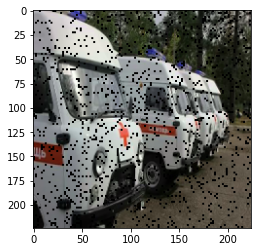

In [ ]:
imshow(trainset[0][0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


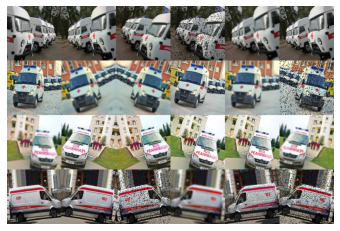

In [ ]:
show_dataset(trainset,m=4)

## Вспомогательные функции 


In [ ]:
def fit(model,loss_func,opt,epochs,train,test,scheduler,checkpoint = True, title='model'):
    """
    Обучает модель.
    :param model: модель
    :param loss_func: функция потерь 
    :param opt: отимизатор
    :param epochs: количество эпох
    :param train: обучающая выборка <DataLoader>
    :param test: тестовая выборка <DataLoader> 
    :param checkpoint: <bool> Включить чекпоинты 
    :param title: название модели (для сохранения чекпоинтов)
    :return : train_loss - лист ошибок на обучающей выборке
              test_loss - лист ошибок на тествоой выборке
              accuracy - лист метрик accuracy для тестовой выборки
    """
    train_loss = []
    test_loss = []
    accuracy = [] 
    best_weights = model.state_dict() 

    
    checkpoint_folder = f'./checkpoint_{title}'
    if os.path.isdir("/content/drive/MyDrive/network/"):
      checkpoint_folder= "/content/drive/MyDrive/network/"+checkpoint_folder

    

    for epoch in tqdm(range(epochs)):
        current_lr = scheduler.get_lr()
        model.train()
        loss_sum = 0 
        for X, y in train: 
            X, y = X.to(device), y.to(device) 
            model.zero_grad()  
            output = model(X)
            loss = loss_func(output, y)
            loss_sum += loss.item()
            loss.backward() 
            opt.step()
        scheduler.step()
        train_loss.append(loss_sum/len(train)) 
        
        correct = 0
        total = 0
        model.eval()
        loss_sum = 0
        with torch.no_grad():
            for X, y in test:
                X, y = X.to(device), y.to(device) 
                output = model(X)
                loss = loss_func(output, y)
                loss_sum += loss.item()
                for idx, i in enumerate(output):
                    if torch.argmax(i) == y[idx]:
                        correct += 1
                    total += 1
            accuracy.append(correct/total)
            test_loss.append(loss_sum/len(test))

        print(f"Epoch {epoch:02}\ttain_loss: {train_loss[-1]:.5f}\ttest_loss: {test_loss[-1]:.5f}\taccuracy: {accuracy[-1]:.5f}\tlr: {current_lr[0]:.5f}")

        # if checkpoint and test_loss[-1] == min(test_loss):
        if checkpoint and accuracy[-1] == max(accuracy):
            checkpoint_path = f'{checkpoint_folder}/{title}-loss:{test_loss[-1]:.3f}-acc:{accuracy[-1]:.3f}.pth'
            if not os.path.isdir(checkpoint_folder):
                os.mkdir(checkpoint_folder)
            torch.save(model.state_dict(), checkpoint_path)

        if accuracy[-1] == max(accuracy):
            best_weights = model.state_dict()

    # Загрузка лучших весов
    model.load_state_dict(best_weights)
    best_idx = accuracy.index(max(accuracy))
    print(f"Установлены лучшие веса: test_loss:{test_loss[best_idx]:.5f}\taccuarcy: {accuracy[best_idx]:.5f} ")

    return train_loss, test_loss, accuracy

In [ ]:
def draw_fit_plot(train_loss, test_loss, accuracy):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_loss, label="train_loss")
    plt.plot(test_loss, label="test_loss",)
    best_epoch = accuracy.index(max(accuracy))
    plt.plot([best_epoch]*2,[0,1],label = 'best epoch')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(accuracy, label="test accuracy")
    plt.legend()

In [ ]:
def evalute(model,dataset):
  model.eval()
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in tqdm(dataset):
          images, labels = data[0].to(device),data[1].to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy on {len(dataset)*len(images)} images : {100 * correct / total:.3f}')

## Transfer learning


In [ ]:
# загружаем предобученную модель
ENClassifier = EfficientNet.from_pretrained('efficientnet-b0',num_classes=5).to(device)

# замораживаем параметры (веса)
for param in ENClassifier.parameters():
    param.requires_grad = False

for param in ENClassifier._fc.parameters():
    param.requires_grad = True

# ENClassifier
# pass

Loaded pretrained weights for efficientnet-b0


In [ ]:
!pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

  Cloning https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to /tmp/pip-req-build-uy_dy_xg
  Running command git clone -q https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup /tmp/pip-req-build-uy_dy_xg
  Created wheel for cosine-annealing-warmup: filename=cosine_annealing_warmup-2.0-cp37-none-any.whl size=3335 sha256=0d96270baa7a75fc94105187c23a2af3eb1ca0eba57c0539ba649b77c9636ea9
  Stored in directory: /tmp/pip-ephem-wheel-cache-bptyguay/wheels/83/a0/62/d58698abb3efe5a814f30e73cff0a16644dc7e125ae5eb92af
Successfully built cosine-annealing-warmup


In [ ]:

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
cosine_annelaing_scheluder = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=0.00001)


In [ ]:

num_epochs = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(ENClassifier._fc.parameters(), lr=0.01)

cosine_annelaing_warmup_scheluder = CosineAnnealingWarmupRestarts(optimizer,
                                                                  first_cycle_steps=5,
                                                                  cycle_mult=1.5,
                                                                  max_lr=0.01,
                                                                  min_lr=0.00001,
                                                                  warmup_steps=1,
                                                                  gamma=0.5)

In [ ]:
name = 'ENClassifier_warmup'
fit_data = fit(ENClassifier,loss_fn,optimizer,num_epochs,trainloader,testloader,cosine_annelaing_warmup_scheluder,title=name)

Epoch 00	tain_loss: 1.62398	test_loss: 1.59946	accuracy: 0.21714	lr: 0.00001
Epoch 01	tain_loss: 0.94162	test_loss: 0.41119	accuracy: 0.84286	lr: 0.01000
Epoch 02	tain_loss: 0.73853	test_loss: 0.59753	accuracy: 0.77000	lr: 0.00854
Epoch 03	tain_loss: 0.66530	test_loss: 0.35669	accuracy: 0.87286	lr: 0.00500
Epoch 04	tain_loss: 0.58002	test_loss: 0.30951	accuracy: 0.88571	lr: 0.00147
Epoch 05	tain_loss: 0.56430	test_loss: 0.30845	accuracy: 0.88000	lr: 0.00001
Epoch 06	tain_loss: 0.72027	test_loss: 0.31052	accuracy: 0.89286	lr: 0.00500
Epoch 07	tain_loss: 0.61070	test_loss: 0.35653	accuracy: 0.87143	lr: 0.00467
Epoch 08	tain_loss: 0.58157	test_loss: 0.27932	accuracy: 0.88857	lr: 0.00375
Epoch 09	tain_loss: 0.49275	test_loss: 0.25609	accuracy: 0.90000	lr: 0.00251
Epoch 10	tain_loss: 0.46145	test_loss: 0.24585	accuracy: 0.91571	lr: 0.00126
Epoch 11	tain_loss: 0.45277	test_loss: 0.24147	accuracy: 0.90857	lr: 0.00034
Epoch 12	tain_loss: 0.52967	test_loss: 0.23708	accuracy: 0.90571	lr: 0.00001

In [ ]:
tr = [line.split('\t') for line in t.splitlines()]

In [ ]:
train = [float(x[1].split()[1]) for x in tr] 
test = [float(x[2].split()[1]) for x in tr]
acc = [float(x[3].split()[1]) for x in tr]

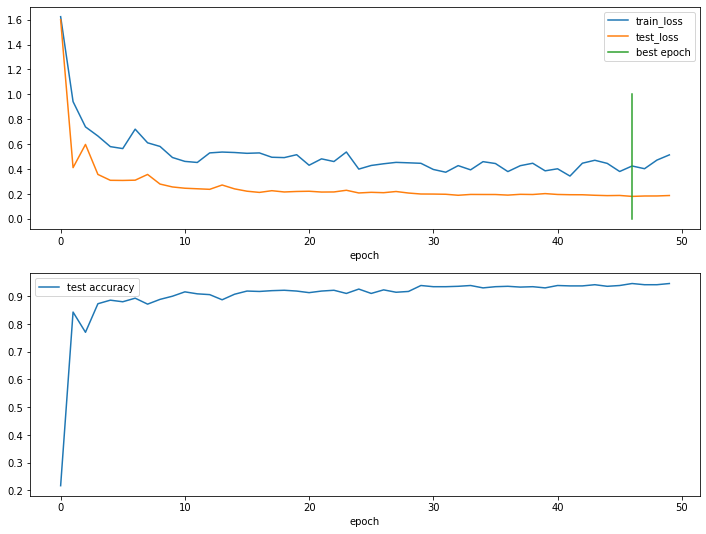

In [ ]:
draw_fit_plot(train,test,acc)

## Проверка точности 

In [ ]:
evalute(ENClassifier,testloader)

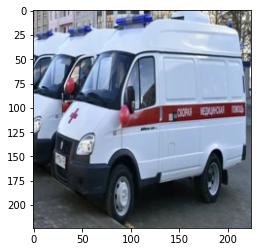

-----
ambulance                                                                   (99.58%)
police                                                                      (0.30%)
common                                                                      (0.11%)
fire-truck                                                                  (0.01%)
tractor                                                                     (0.00%)


In [ ]:
predict_img(croped_imgs[6],ENClassifier,classes)

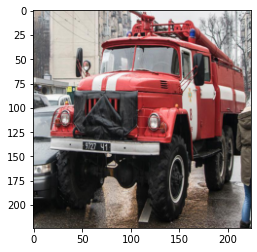

-----
fire-truck                                                                  (85.01%)
tractor                                                                     (9.22%)
common                                                                      (3.50%)
ambulance                                                                   (2.18%)
police                                                                      (0.09%)


In [ ]:
predict_img(croped_imgs[2],ENClassifier,classes)

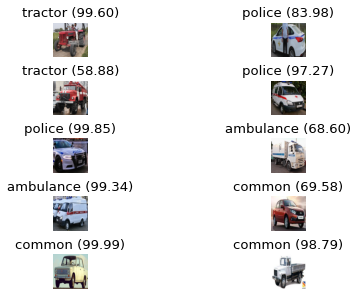

In [ ]:
predict_few(croped_imgs,ENClassifier,classes)

# Общая модель


## Функции

In [ ]:
# Функции для нарезки картинки 

def save_one_box(xyxy, im, file='image.jpg', gain=1.02, pad=10, square=False, BGR=False, save=True):
    # Save image crop as {file} with crop size multiple {gain} and {pad} pixels. Save and/or return crop
    xyxy = torch.tensor(xyxy).view(-1, 4)
    b = xyxy2xywh(xyxy)  # boxes
    if square:
        b[:, 2:] = b[:, 2:].max(1)[0].unsqueeze(1)  # attempt rectangle to square
    b[:, 2:] = b[:, 2:] * gain + pad  # box wh * gain + pad
    xyxy = xywh2xyxy(b).long()
    clip_coords(xyxy, im.shape)
    crop = im[int(xyxy[0, 1]):int(xyxy[0, 3]), int(xyxy[0, 0]):int(xyxy[0, 2]), ::(1 if BGR else -1)]

    return crop

def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y


def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

def clip_coords(boxes, shape):
    # Clip bounding xyxy bounding boxes to image shape (height, width)
    if isinstance(boxes, torch.Tensor):  # faster individually
        boxes[:, 0].clamp_(0, shape[1])  # x1
        boxes[:, 1].clamp_(0, shape[0])  # y1
        boxes[:, 2].clamp_(0, shape[1])  # x2
        boxes[:, 3].clamp_(0, shape[0])  # y2
    else:  # np.array (faster grouped)
        boxes[:, [0, 2]] = boxes[:, [0, 2]].clip(0, shape[1])  # x1, x2
        boxes[:, [1, 3]] = boxes[:, [1, 3]].clip(0, shape[0])  # y1, y2

# Функция для классификатора
def predict(img,classifier):
  """
   Классифицирует картинку
  :param img: картинка 
  :param classifier: классификатор
  """
  classifier.eval()
  
  output_dict = {}
  with torch.no_grad():
      outputs = classifier(img.unsqueeze(0).to(device))
  
      for idx in torch.topk(outputs, len(outputs[0])).indices.squeeze(0).tolist():
        prob = torch.softmax(outputs, dim=1)[0, idx].item()
        output_dict[idx] = prob
  
  return output_dict

def display_prediction(img,prediction_dict,labels):
    """
    Отображает картинку и предсказания вероятности всех классов
    :param img: картинка 
    :param prediction_dict: словарь с предсказаниями
    :param labels: подписи классов
    """
    
    # Print predictions
    
    cell_text = []
    # print('-----')
    for cls, prob in prediction_dict.items():
        cell_text.append([labels[cls],f'{prob*100:.2f}%'])
        # print(f'{labels[cls]:<75} ({prob*100:.2f}%)')
    the_table = plt.table(cellText=cell_text,colLabels=['Class',"prob"] ,loc="right")
    imshow(img)

def imshow(img):
    """
    Отображает картинку 
    :param img: нормализованный тензор - картинка 
    """
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def recognize_images(imgs,model,n=-1,extended = False):
  """
    Последовательно загружает картинки в модель
    :param imgs: список картинок
    :param model: модель
    # :param n: количество картинок из списка для распозанвания
    :param extended: отображать вероятности для всех классов у каждой картинки
    """
  pred_list = []
  classes = model.FINAL_CLASSES
  for i,img in enumerate(imgs):
    if extended:
      print(i+1)
      plt.subplot()
      model.recognize(img)
    else:
      pred_dict = model.recognize(img,display=False)
      idx = max(pred_dict , key = pred_dict.get)
      pred_list.append(f'{classes[idx]} ({pred_dict[idx]*100:.1f}%)')

  if extended:
    return
  else:
    tfms = transforms.Compose([transforms.Resize((224,224)),
                           transforms.ToTensor(),
                           transforms.Normalize(0.5, 0.5, 0.5)])
    tr_imgs = list(map(tfms,imgs))
    fig = plt.figure(figsize=(20, 12), dpi=300)
    imshow(torchvision.utils.make_grid(tr_imgs))
    print(*pred_list)


## Описание модели 


In [ ]:
class CarRecognizer():
  def __init__(self,yolo,classifier):
    self.yolo = yolo
    self.classifier = classifier
    self.YOLO_CLASSES = [ 'car', 'truck', 'bus']
    self.FINAL_CLASSES = ['ambulance', 'common', 'fire-truck', 'police', 'tractor']

  def recognize(self,img,display = True):
    """
    Распознает машину на картинке
    :param img: PIL картинка
    """
    # распознаем картинку с помощью yolo
    yolo_res = self.yolo(img)

    # отрезаем лишнее, оставяем наибольший кусок
    isvehicle = False # флаг машины на картинке

    names = yolo_res.names
    _, det = next(enumerate(yolo_res.pred))
    main_crop = img.copy()
    max_size = (1,1)
    
    for *xyxy, conf, cls in reversed(det):
      c = int(cls)  # integer class
      if names[c] in self.YOLO_CLASSES: 
          isvehicle = True
          crop= save_one_box(xyxy, np.array(img), BGR=True)
          crop = Image.fromarray(crop)
          if crop.size>max_size:
              max_size = crop.size
              main_crop = crop
    
    if not isvehicle:
      print("There is no vehicle in the picture")
      return -1
    
    # Нормируем картинку
    tfms = transforms.Compose([transforms.Resize((224,224)),
                           transforms.ToTensor(),
                           transforms.Normalize(0.5, 0.5, 0.5)])
    main_crop = tfms(main_crop)

    pred = predict(main_crop,self.classifier)  
    if display:
      display_prediction(main_crop,pred,self.FINAL_CLASSES) 

    return pred
 

## Загрузка моделей-компонет


In [ ]:
# Загрузка yolov5 и классификатора на основе EfficientNet
yolov5 = torch.hub.load('ultralytics/yolov5', 'yolov5s')
yolov5.eval()
# загружаем предобученную модель
ENClassifier = EfficientNet.from_pretrained('efficientnet-b0',num_classes=5).to(device)

# замораживаем параметры (веса)
for param in ENClassifier.parameters():
    param.requires_grad = False

for param in ENClassifier._fc.parameters():
    param.requires_grad = True


PATH  ="/content/drive/MyDrive/network/checkpoint_ENClassifier_warmup/ENClassifier_warmup-loss:0.180-acc:0.947.pth"
ENClassifier.load_state_dict(torch.load(PATH,map_location=device))
ENClassifier.eval()
pass

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2021-7-19 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 



requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 


Loaded pretrained weights for efficientnet-b0


In [ ]:
# Загрузка тестовых данных

img_folder_path = 'drive/MyDrive/pics'
tr = transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Resize((500,500)),
                         transforms.Normalize(0.5,0.5)])
import glob
imgs = []
for filename in glob.glob(f'{img_folder_path}/*.jpg'):
    im=Image.open(filename)
    imgs.append(im)
print(f"Found {len(imgs)} pics in {img_folder_path}/")

imshow(torchvision.utils.make_grid(list(map(tr,imgs))))


Found 10 pics in drive/MyDrive/pics/


## Применение модели

In [ ]:
model = CarRecognizer(yolov5,ENClassifier)

In [ ]:
model.FINAL_CLASSES

['ambulance', 'common', 'fire-truck', 'police', 'tractor']

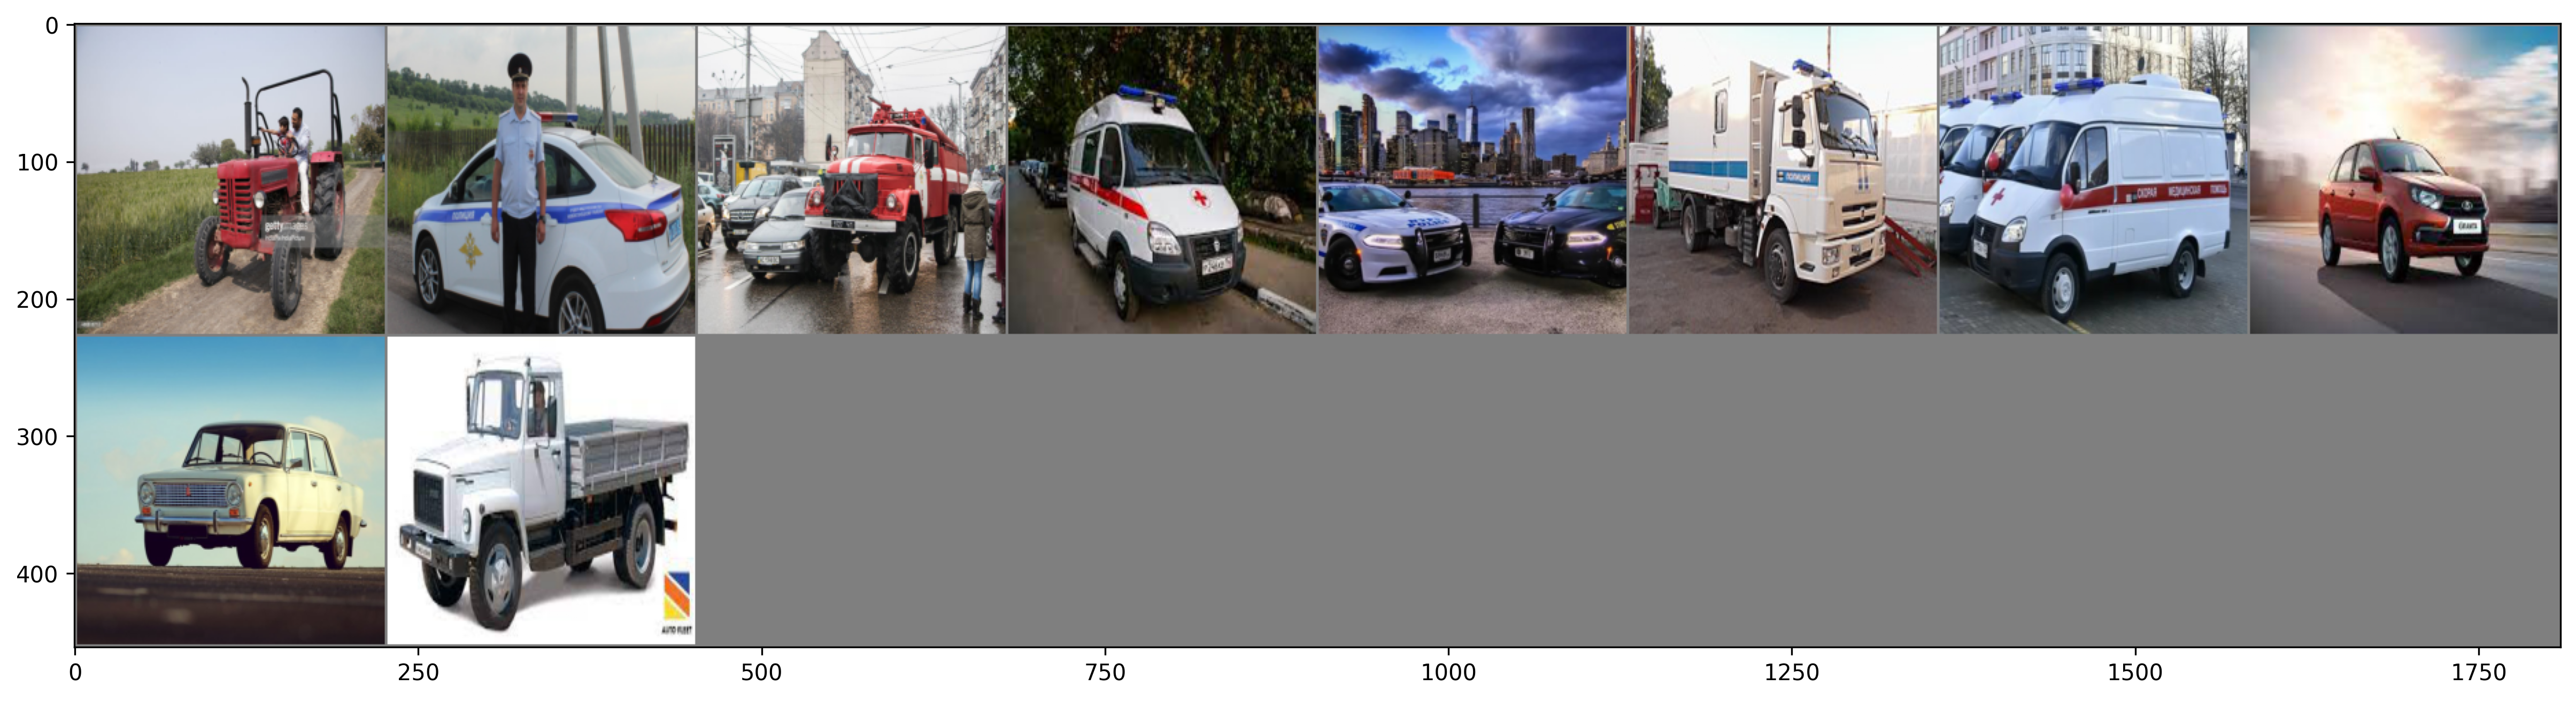

tractor (98.1%) ambulance (64.0%) fire-truck (88.8%) ambulance (99.1%) police (99.9%) common (78.6%) ambulance (99.6%) common (87.0%) common (99.7%) common (98.1%)


In [ ]:
recognize_images(imgs,model)

1


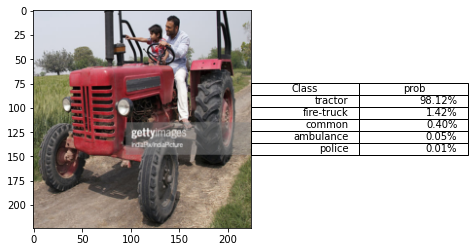

2


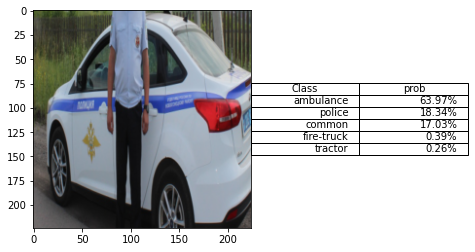

3


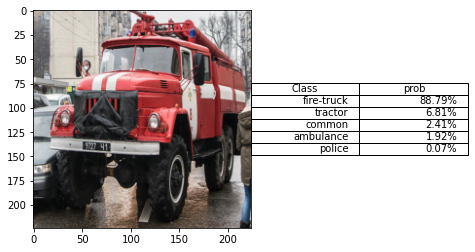

4


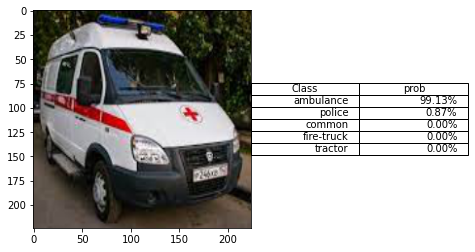

5


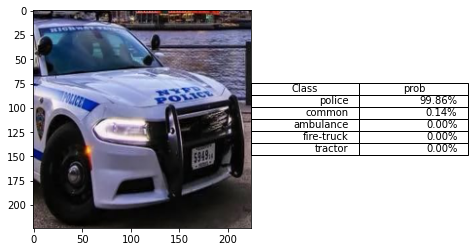

6


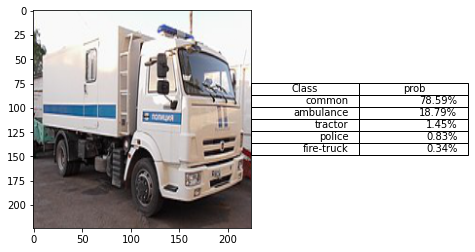

7


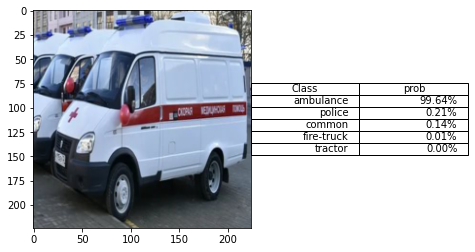

8


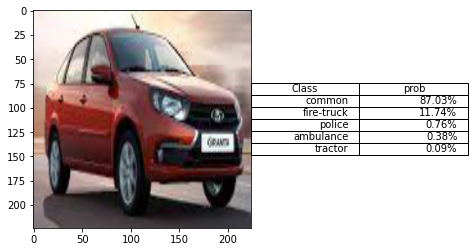

9


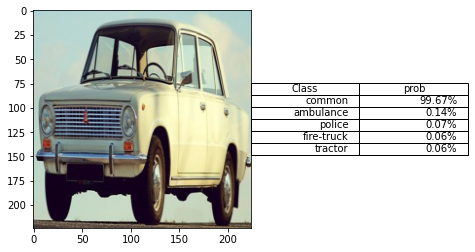

10


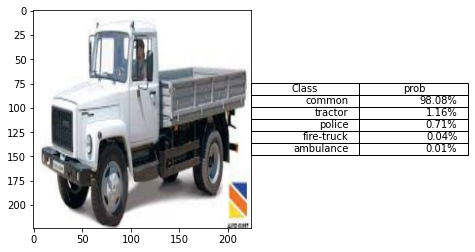

In [ ]:
recognize_images(imgs,model,extended=True)

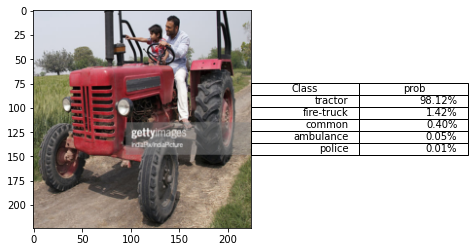

In [ ]:
pred = model.recognize(imgs[0]) # верно 

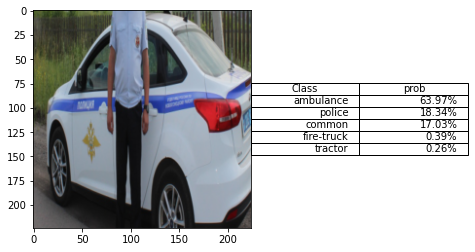

In [ ]:
pred = model.recognize(imgs[1]) #неверно 

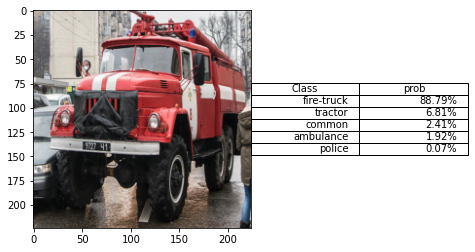

In [ ]:
pred = model.recognize(imgs[2]) #верно 

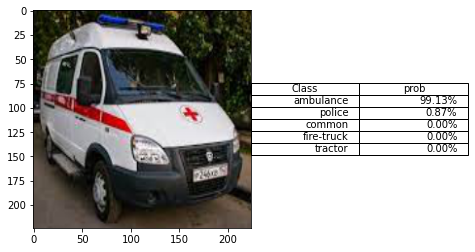

In [ ]:
pred = model.recognize(imgs[3]) #верно 

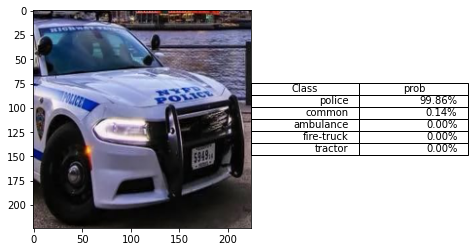

In [ ]:
pred = model.recognize(imgs[4]) #верно 

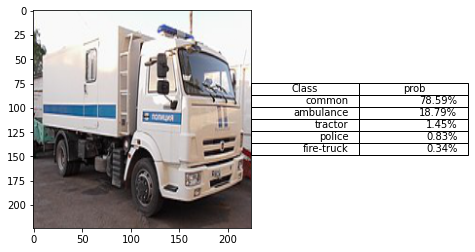

In [ ]:
pred = model.recognize(imgs[5]) #неверно 

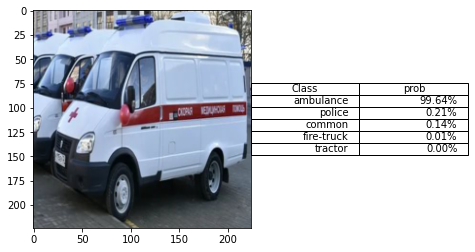

In [ ]:
pred = model.recognize(imgs[6]) #верно 